# Time Series Forecasting for Future Sales
---
**Submitted by: Sheetal Bongale | March 2021**

Steps -
1. **Data Wrangling and Exploratory Data Analysis**
2. **Feature Engineering and Selection**
3. Modeling and forecasting
4. Model evaluation and validation
5. Sales quantity forecast results and visualization
6. Final results and analysis report

## 1. Read data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

pio.renderers
pio.renderers.default='notebook+jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv("data/Online Retail.csv", encoding= 'unicode_escape')
df.head()            

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## 2. Data exploration

In [3]:
# size of the df
df.shape

(541909, 8)

In [4]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# number of unique values for each column
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
# top 10 countries by value counts
df['Country'].value_counts().head(10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

## 3. Data Cleaning

#### Missing/NaN values

In [8]:
# Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Dropping `CustomerID` column 

In [9]:
df['CustomerID'].nunique()

4372

In [10]:
df = df.dropna(subset=['CustomerID'])

In [11]:
df['CustomerID'].nunique()

4372

In [12]:
# Checking for missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Out of stock items

In [13]:
# Analyze quantities that are out of stock
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/10 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/10 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/10 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/11 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/11 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/11 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/11 11:58,1.25,17315.0,United Kingdom


Looks like out of stock  items are labeled with 'C' in the invoice table.

Lets drop these rows as they don’t contribute to the future sales
but first lets confirm this.

In [14]:
df[df['InvoiceNo'].str.contains('C', na = False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/10 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/10 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/10 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/10 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/11 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/11 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/11 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/11 11:58,1.25,17315.0,United Kingdom


In [15]:
# Drop items that are out of stock
df = df[~df['InvoiceNo'].str.contains('C', na = False)]

In [16]:
df.shape

(397924, 8)

#### Unit Price 

In [17]:
df.UnitPrice.describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

Looks like there are some unit prices that are $0.

Lets take a look at the items with large quantity but 0 unit price


In [18]:
df.loc[df.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/11 15:57,0.0,13256.0,United Kingdom
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,8/11/11 11:42,0.0,14911.0,EIRE
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,11/3/11 11:26,0.0,12415.0,Australia
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,8/26/11 14:19,0.0,14646.0,Netherlands
314747,564651,22955,36 FOIL STAR CAKE CASES,144,8/26/11 14:19,0.0,14646.0,Netherlands


In [19]:
# Drop all the items that have 0 unit price
df = df.loc[df.UnitPrice > 0]

In [20]:
df.Quantity.describe()

count    397884.000000
mean         12.988238
std         179.331775
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

### 3.1 Convert datetime columns

In [21]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [22]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

df["Year"] = df.InvoiceDate.dt.year
df["Quarter"] = df.InvoiceDate.dt.quarter
df["Month"] = df.InvoiceDate.dt.month
df["Week"] = df.InvoiceDate.dt.isocalendar().week
df["Day"] = df.InvoiceDate.dt.day
df["Weekday"] = df.InvoiceDate.dt.weekday

df["Date"] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [23]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Week,Day,Weekday,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,4,12,48,1,2,2010-12-01


## 4. Data Visualization

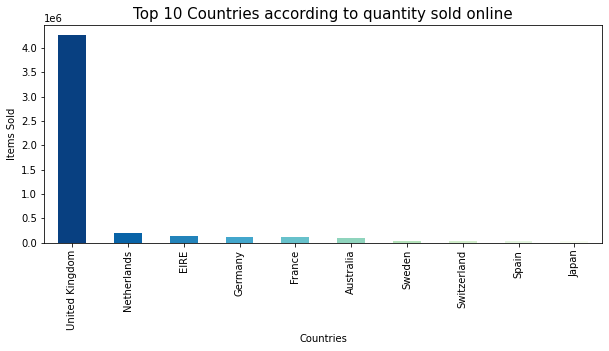

In [24]:
color = plt.cm.GnBu(np.linspace(1, 0, 10))
countries_10 = df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = False).head(10)
countries_10.plot.bar(figsize = (10, 4),color = color)

plt.title('Top 10 Countries according to quantity sold online', fontsize = 15)
plt.xlabel('Countries')
plt.ylabel('Items Sold')
plt.show()

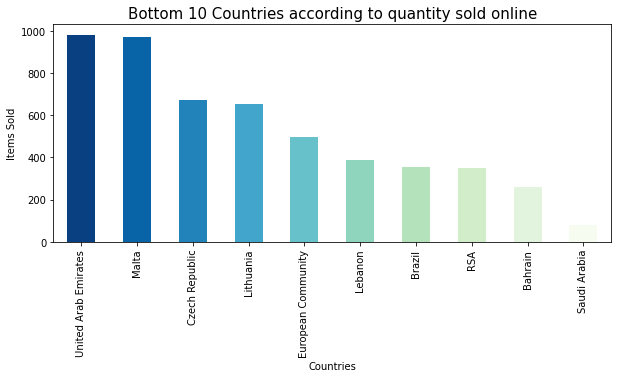

In [25]:
color = plt.cm.GnBu(np.linspace(1, 0, 10))
countries_10 = df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = False).tail(10)
countries_10.plot.bar(figsize = (10, 4),color = color)

plt.title('Bottom 10 Countries according to quantity sold online', fontsize = 15)
plt.xlabel('Countries')
plt.ylabel('Items Sold')
plt.show()

In [26]:
df_countries = pd.DataFrame(df.groupby(['Country']).sum()['Quantity']).reset_index().sort_values(by=['Quantity'], ascending = False)
df_countries.head()

,Country,Quantity
35,United Kingdom,4256740
23,Netherlands,200361
10,EIRE,140275
14,Germany,119261
13,France,111471


In [27]:
fig = go.Figure(data=go.Choropleth(
    locations = df_countries['Country'],
    z = df_countries['Quantity'],
    text = df_countries['Country'],
    colorscale = 'Tealgrn',
    locationmode='country names',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Sale Quantity',
    zmax = 200000,
    zmin = 10000
))

fig.update_layout(
    title_text='Quantity by country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

### Daily Sales

In [28]:
df['Total_Sales'] = df['Quantity'] * df['UnitPrice']
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Week,Day,Weekday,Date,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,4,12,48,1,2,2010-12-01,15.3


In [29]:
daily_quantity = df.groupby(['Date'])['Quantity'].sum().reset_index()
daily_quantity.head()

,Date,Quantity
0,2010-12-01,24215
1,2010-12-02,31142
2,2010-12-03,11839
3,2010-12-05,16449
4,2010-12-06,16291


In [57]:
fig = go.Figure(data=[go.Scatter(x=daily_quantity.Date, y=daily_quantity.Quantity, line_color='darkturquoise')])
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Total Quantity", 
                  title='Daily Sales by Quantity',
                  height=400,
                 template='ggplot2')
fig.show()

In [31]:
df_daily_amount = df.groupby(['Date'])['Total_Sales'].sum().reset_index()
df_daily_amount.head()

,Date,Total_Sales
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-05,31771.60
4,2010-12-06,31215.64


In [56]:
fig = go.Figure(data=[go.Scatter(x=df_daily_amount.Date, y=df_daily_amount.Total_Sales, line_color='darkturquoise')])
fig.update_layout(xaxis_title="Date", yaxis_title="Total Sales Amount", title='Daily Sales Revenue',height=400, template='ggplot2')
fig.show()

###  Top 3 selling items
We define top selling items as items which had the greatest total sales over this
week across all countries.

In [33]:
top_3 = df.groupby(['Description']).sum()['Quantity'].reset_index().sort_values(by=['Quantity'], ascending = False)
top_3.head(3)

,Description,Quantity
2319,"PAPER CRAFT , LITTLE BIRDIE",80995
1992,MEDIUM CERAMIC TOP STORAGE JAR,77916
3786,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415


In [34]:
# Lets check what are the top 3 selling items with respect to total revenue
df.groupby(['Description']).sum()['Total_Sales'].reset_index().sort_values(by=['Total_Sales'], ascending = False).head(3)

,Description,Total_Sales
2319,"PAPER CRAFT , LITTLE BIRDIE",168469.60
2767,REGENCY CAKESTAND 3 TIER,142592.95
3698,WHITE HANGING HEART T-LIGHT HOLDER,100448.15


In [35]:
df_top3 = df.loc[(df['Description']=='PAPER CRAFT , LITTLE BIRDIE') | 
       (df['Description']=='MEDIUM CERAMIC TOP STORAGE JAR') |
      (df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS')]
df_top3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Week,Day,Weekday,Date,Total_Sales
3259,536615,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-02 10:09:00,0.29,14047.0,United Kingdom,2010,4,12,48,2,3,2010-12-02,13.92
3297,536618,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-02 10:17:00,0.29,17017.0,United Kingdom,2010,4,12,48,2,3,2010-12-02,13.92
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom,2010,4,12,48,2,3,2010-12-02,518.40
5047,536839,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,288,2010-12-02 18:25:00,0.21,15093.0,United Kingdom,2010,4,12,48,2,3,2010-12-02,60.48
5278,536856,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-03 10:26:00,0.29,13370.0,United Kingdom,2010,4,12,48,3,4,2010-12-03,13.92


In [36]:
df_top3.describe()

,Quantity,UnitPrice,CustomerID,Year,Quarter,Month,Week,Day,Weekday,Total_Sales
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,317.449405,0.568601,15312.206845,2010.956845,2.915179,7.797619,31.831845,15.409226,2.470238,392.072292
std,4238.843131,0.431512,1662.475798,0.203357,0.991894,2.979432,12.917253,8.674995,1.828490,7143.291382
min,1.000000,0.180000,12346.000000,2010.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.290000
25%,12.000000,0.290000,14014.250000,2011.000000,2.000000,5.000000,21.000000,8.000000,1.000000,13.920000
50%,48.000000,0.290000,15279.000000,2011.000000,3.000000,8.000000,34.000000,15.000000,2.000000,13.920000
75%,48.000000,1.250000,16684.250000,2011.000000,4.000000,10.000000,43.000000,23.000000,4.000000,15.000000
max,80995.000000,2.080000,18272.000000,2011.000000,4.000000,12.000000,51.000000,31.000000,6.000000,168469.600000


In [37]:
df_top3.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Quarter        0
Month          0
Week           0
Day            0
Weekday        0
Date           0
Total_Sales    0
dtype: int64

In [44]:
df_top3.to_csv("data/top_selling_data.csv", index=False)

### Testing for stationarity

In [42]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags used','Number of observations used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [43]:
adfuller_test(df_top3['Quantity'])

ADF Test Statistic : -17.547522336842647
p-value : 4.158677646372377e-30
#Lags used : 0
Number of observations used : 671
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Autocorrelation and Partial Autocorrelation

In [39]:
output = adfuller(daily_quantity.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -1.29 and P value: 0.63199


In [40]:
d=1
series_date = daily_quantity.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -17.04 and P value: 0.00000


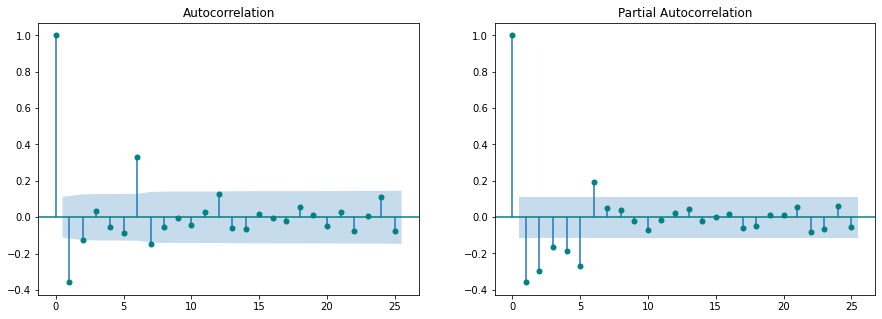

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

In [55]:
fig = go.Figure(data=[go.Scatter(x=daily_quantity.Date,y=daily_quantity.Quantity, line_color = 'darkturquoise')])
fig.update_layout(xaxis_title="Date",yaxis_title="Quantity",title='Daily Trend', height=400,template='ggplot2')
fig.show()

In [ ]:
train, test = X[0:-12], X[-12:]